### Useful links
- [CampusX - Handwritten Digit Classification using ANN](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Shubham Singh - The EMNIST dataset letter recognition](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Emnist classification](https://github.com/sejalgupta01/EMNIST-Classification/blob/master/EMNIST_Classification%20(3).ipynb)
- [Deep learning-Deep understanding by shubham singh](https://www.youtube.com/playlist?list=PL2FZtB-DAFqk4iXGu1xK1_fUmTCjtfQhV)
- [Neural Network from Scratch | Mathematics & Python Code](https://www.youtube.com/watch?v=pauPCy_s0Ok)
- https://github.com/khelli07/ai-fnn/blob/main/README.md
- https://khelli07.medium.com/introduction-to-artificial-neural-network-in-deep-learning-aa7ba2280f50
- https://khelli07.medium.com/feedforward-neural-network-fnn-implementation-from-scratch-using-python-467f51ecca3d
- https://towardsdatascience.com/creating-neural-networks-from-scratch-in-python-6f02b5dd911
- https://subscription.packtpub.com/book/data/9781789346640/1/ch01lvl1sec05/feed-forward-propagation-from-scratch-in-python
- [Softmax Layer from Scratch ](https://www.youtube.com/watch?v=AbLvJVwySEo)

### Dependencies

In [2]:
# ! pip install torchvision
# ! pip install tqdm
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install seaborn

In [3]:
# fix random seed
import numpy as np
np.random.seed(0)
np.random.RandomState(0)

# torch random seed
import torch
torch.manual_seed(0)

import torchvision.datasets as ds
import torchvision.transforms as transforms
from tqdm import tqdm

### Dataset

In [4]:
# Download the training and validation datasets

train_val_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)


100%|██████████| 561753746/561753746 [00:23<00:00, 24218845.48it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [5]:

test_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=False,
    transform=transforms.ToTensor(),
)


### Preprocessing

In [6]:
# get labels
labels = np.array(train_val_ds.targets)
# get unique labels
unique_labels = np.unique(labels)

# print number of samples per class
for label in unique_labels:
    print(f"number of samples for class {label}: {np.sum(labels == label)}")

number of samples for class 1: 4800
number of samples for class 2: 4800
number of samples for class 3: 4800
number of samples for class 4: 4800
number of samples for class 5: 4800
number of samples for class 6: 4800
number of samples for class 7: 4800
number of samples for class 8: 4800
number of samples for class 9: 4800
number of samples for class 10: 4800
number of samples for class 11: 4800
number of samples for class 12: 4800
number of samples for class 13: 4800
number of samples for class 14: 4800
number of samples for class 15: 4800
number of samples for class 16: 4800
number of samples for class 17: 4800
number of samples for class 18: 4800
number of samples for class 19: 4800
number of samples for class 20: 4800
number of samples for class 21: 4800
number of samples for class 22: 4800
number of samples for class 23: 4800
number of samples for class 24: 4800
number of samples for class 25: 4800
number of samples for class 26: 4800


In [7]:
# remove 'N/A' label and decrease all labels by 1
train_val_ds.targets = train_val_ds.targets - 1
test_ds.targets = test_ds.targets - 1

train_val_ds.classes = train_val_ds.classes[1:]
test_ds.classes = test_ds.classes[1:]

#### Data Normalization

In [8]:
# next issue: do we need to normalize the data?
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
# normalize the data
train_val_ds.data = train_val_ds.data / torch.max(train_val_ds.data)
test_ds.data = test_ds.data / torch.max(test_ds.data)

### Train-validation split
The dataset contains 28x28 images of letters from the Latin alphabet. Split the train-validation dataset as 85%-15% to form your train set and validation set. 

In [10]:
# convert torch to numpy
train_val_ds.data = train_val_ds.data.numpy()
train_val_ds.targets = train_val_ds.targets.numpy()

# convert torch to numpy
test_ds.data = test_ds.data.numpy()
test_ds.targets = test_ds.targets.numpy()

In [11]:
# use sklearn to split train_validation_dataset into train and validation datasets
from sklearn.model_selection import train_test_split

val_per = 0.15 # validation percentage

# split train_validation_dataset into train and validation datasets as 85% and 15% respectively
train_ds, val_ds, train_labels, val_labels = train_test_split(
    train_val_ds.data,
    train_val_ds.targets,
    test_size=val_per,
    random_state=1,
)

### FFN implementation

##### Loss function
As you can see, our example model is currently random. To remedy this, we need a way to
calculate how wrong the neural network is at current predictions and begin adjusting weights
and biases to decrease error over time. Thus, our next step is to quantify how wrong the model is
through what’s defined as a loss function.

In [12]:
# no matter which loss function we’ll use, the overall loss is always a mean value of all sample losses
# common loss functions
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

##### Activation function

In [13]:
class Activation:
    def forward(self, inputs):
        raise NotImplementedError
    def backward(self, grad_outputs):
        raise NotImplementedError
    

In [14]:
# ReLU activation
class ReLU(Activation):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad_outputs):
        # Since we need to modify original variable,
        # let’s make a copy of values first
        grad_inputs = grad_outputs.copy()

       # print(f"Relu grad_output shape: {grad_outputs.shape}")

        # Zero gradient where input values were negative
        grad_inputs[self.inputs <= 0] = 0

       # print(f"Relu grad_input shape: {grad_inputs.shape}")

        return grad_inputs

In [15]:
class Softmax(Activation):

    def forward(self, inputs):
        # get row max to subtract from each row
        # this is to prevent overflow
        # the max value in each row will be 0
        # the output will be extactly the same
        row_maxs = np.max(inputs, axis=1, keepdims=True)

        # Get unnormalized probabilities
        # exponentiate values
        exp_values = np.exp(inputs - row_maxs)

        # Get normalization bases for each sample
        norm_bases = np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        probabilities = exp_values / norm_bases

        #print(f"softmax forward output shape: {probabilities.shape}")

        self.outputs = probabilities

        return probabilities
    

    # back propagation
    def backward(self, grad_output):
        # return input_grads
       # print(f"softmax-> grad_output shape: {grad_output.shape}")
        grad_input = self.outputs * (grad_output - np.sum(self.outputs * grad_output, axis=-1, keepdims=True))
       # print(f"softmax-> grad_input shape: {grad_input.shape}")
        return grad_input

In [16]:
class Optimizer:
    # Update parameters
    def update_weights(self, weights, grad_weights):
        raise NotImplementedError
    # update bias
    def update_bias(self, bias, grad_bias):
        raise NotImplementedError

##### layer

In [17]:
class Layer:
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, grad_outputs, optimizer=None):
        raise NotImplementedError
    
    def summary(self):
        raise NotImplementedError

In [18]:
class Flatten(Layer):
    def __init__(self):
        self.input_shape = None
    
    def forward(self, inputs):
        # chec if 2D for batch size
        if len(inputs.shape) <= 1:
            raise ValueError(f"Flatten layer input shape must be greater than 1D. Got {inputs.shape}.")

        # save shape for backward pass
        self.input_shape = inputs.shape

        # flatten inputs
        return inputs.reshape(inputs.shape[0], -1)
    
    def backward(self, grad_outputs, optimizer=None):
        # reshape gradient
        return grad_outputs.reshape(self.input_shape)
    
    def summary(self):
        return "Flatten"

In [19]:
# Dense or fully connected layer
class DenseLayer(Layer):
    # Here, we’re setting weights to be random and biases to be 0
    def __init__(self, 
                 n_inputs:int, 
                 n_neurons:int, 
                 activation:Activation,
                 learning_rate:float = 0.001,
                 debug:bool = False,
                 ) -> None:
        # Xavier initialization
        # We divide by n_inputs to reduce the variance of our outputs
        # and make sure that they are all in the same range
        self.weights = np.random.randn(n_inputs, n_neurons) / np.sqrt(n_inputs)

        # print max and min weights
        if debug:
            print(f"weights shape: {self.weights.shape}")
            print(f"weight (min, max) = ({np.min(self.weights)}, {np.max(self.weights)})")
           
        # xaiver initialization
        self.biases = np.zeros((1, n_neurons))

        if debug:
            print(f"baises shape: {self.biases.shape}")
            print(f"bias (min, max) = ({np.min(self.biases)}, {np.max(self.biases)})")
            

        # activation function
        self.activation = activation
        # learning rate
        self.learning_rate = learning_rate

    # Forward pass
    # When we pass data through a model from beginning to end, this is called a forward pass. 
    def forward(self, inputs:np.ndarray):
        # check input shape
        if len(inputs.shape) != 2:
            raise ValueError(f"input shape must be 2D, got {len(inputs.shape)}D")
        
        # save input
        self.inputs = inputs

        # inputs shape: (batch_size, n_inputs)
        # weights shape: (n_inputs, n_neurons)
        # biases shape: (1, n_neurons)
        # output shape: (batch_size, n_neurons) i.e for each sample, we get n_neurons outputs
        out =  np.dot(inputs, self.weights) + self.biases
     
        out = self.activation.forward(out)
        return out
    
    def backward(self, grad_output:np.ndarray, optimizer:Optimizer):
        # activation function derivative
        grad_output = self.activation.backward(grad_output)

      #  print(f"denselayer-> grad_output shape: {grad_output.shape}")

        # Gradients on parameters
        # dE/dW = dE/dY * dY/dW = dE/dY * X.T
        grad_weights = np.dot(self.inputs.T, grad_output)

        # dE/dB = dE/dY * dY/dB = dE/dY * 1
        grad_biases = grad_output.mean(axis=0) * self.inputs.shape[0]

        # Gradient on values
        # dE/dX = dE/dY * dY/dX = W.T * dE/dY
        grad_inputs = np.dot(grad_output, self.weights.T)

    
        self.weights = optimizer.update_weights(self.weights, grad_weights)
        self.biases = optimizer.update_bias(self.biases,grad_biases)

        return grad_inputs
    
    def summary(self):
        activation_name = self.activation.__class__.__name__
        return f"Dense({self.weights.shape[0]}, {self.weights.shape[1]}), activation: {activation_name}"
    

#### Dropout layer

In [20]:
# Dropout
class DropoutLayer:
    # Init
    def __init__(self, dropout_rate=0.3):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - dropout_rate

    # Forward pass
    def forward(self, inputs):
        # Generate and save scaled mask
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        # Apply mask to output values
        return inputs * self.mask

    # Backward pass
    def backward(self, grad_output, _):
        # Gradient on values
        return grad_output * self.mask
    
    def summary(self):
        return f"Dropout(rate: {1-self.rate})"

#### Categorical cross entropy derivative

In [21]:
class CategoricalCrossEntropyLoss(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values-only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        
        return negative_log_likelihoods
    
    def backward(self, y_pred, y_true):
        # Number of samples
        samples = len(y_pred)

        # Number of labels in every sample
        # We’ll use the first sample to count them
        labels = len(y_pred[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        epsilon = 1e-7

        # Calculate gradient
        grad_output = -y_true / (y_pred+epsilon)
        # Normalize gradient
        grad_output = grad_output / samples

        return grad_output

#### Optimizer

In [22]:
# SGD
class SGD(Optimizer):
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate:float = 1.0) -> None:
        self.learning_rate = learning_rate

    # Update parameters
    def update_weights(self, weights, grad_weights):
        return weights - grad_weights * self.learning_rate
    
    # update bias
    def update_bias(self, bias, grad_bias):
        return bias - grad_bias * self.learning_rate

#### Model

In [23]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []
    
    def append(self, loss, accuracy, val_loss, val_accuracy, val_f1):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.val_loss.append(val_loss)
        self.val_accuracy.append(val_accuracy)
        self.val_f1.append(val_f1)

In [24]:
class BestModel:
    def __init__(self) -> None:
        self.layers = None
        self.loss = np.inf
        self.accuracy = 0
        self.f1 = 0 

    def update(self, layers, loss, accuracy, f1):
        if f1 > self.f1:
            self.layers = layers.copy()
            self.loss = loss
            self.accuracy = accuracy
            self.f1 = f1

    def _forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

In [25]:
# import pickle
import pickle
# import sklern for f1 score
from sklearn.metrics import f1_score
# import confusion matrix
from sklearn.metrics import confusion_matrix
# import accuracy score
from sklearn.metrics import accuracy_score

# import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

class FNN:
    def __init__(self, 
                 loss:Loss, 
                 optimizer:Optimizer, 
                 learning_rate:float = 0.005,
                 layers:list = [],
                 debug:bool = False,
                 ) -> None:
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.debug = debug

        # history
        self.history = History()
        # best model
        self.best_model = BestModel()
        # layers
        self.layers = layers

    def add(self, layer:Layer):
        self.layers.append(layer)

    # add multiple layers
    def add_all(self, layers:list):
        self.layers.extend(layers)

    # summary
    def summary(self):
        print(f"Model summary")
        print(f"==============")
        optimizer = self.optimizer.__class__.__name__
        print(f"Optimizer: {optimizer}")
        loss = self.loss.__class__.__name__
        print(f"Loss: {loss}")
        learning_rate = self.learning_rate
        print(f"Learning rate: {learning_rate}")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.summary()}")
        print(f"Output shape: {self.layers[-1].weights.shape[1]}")

    def save(self, path):
        # clear unnecessary data
        for layer in self.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        self.best_model = None
        self.history = None

        # save model
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def save_best_model(self, path):
        # clear unnecessary data
        for layer in self.best_model.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        # save best model
        with open(path, "wb") as f:
            pickle.dump(self.best_model, f)

    # load best model
    def load_best_model(self, path):
        # load model
        with open(path, "rb") as f:
            self.best_model = pickle.load(f)

    @staticmethod
    def load(path):
        # load model
        with open(path, "rb") as f:
            return pickle.load(f)

    def _forward(self, X):
        # Forward propagation
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def _backward(self, grad_output):
        # Back propagation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, self.optimizer)
        return grad_output

    def _calculate_accuracy(self, y_pred, y_true):
        # Calculate an accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        return accuracy_score(y_true, y_pred_labels)
    

    def evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    def predict(self, X):
        # Calculate an accuracy
        y_pred = self._forward(X)
        return y_pred

    def best_model_predict(self, X):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X)
        return y_pred
    
    def best_model_evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    
    def shuffle(self, X, y):
        # X and y has different shape
        # so we need to shuffle them together
        # create random index
        random_index = np.random.permutation(len(X))
        # shuffle X and y
        return X[random_index], y[random_index]
    
    
    def fit(self, X, y, X_val, y_val, epochs:int = 5, batch_size:int = 32, best_name="best_model.pkl"):
        # initialize history
        self.history = History()
        # initialize best model
        self.best_model = BestModel()

        # iterate over epochs
        # use tqdm to show progress bar
      
        for epoch in range(epochs):
            # shuffle X and y
            X, y = self.shuffle(X, y)

            epoch_loss = 0
            epoch_accuracy = 0

            # calculate number of batches
            batches = len(X) // batch_size
            if len(X) % batch_size != 0:
                batches += 1

            with tqdm(total=batches, desc="Training", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
                # iterate over batches
                for batch in range(batches):
                    # get batch start and end index
                    X_batch = X[batch*batch_size:(batch+1)*batch_size]
                    y_batch = y[batch*batch_size:(batch+1)*batch_size]

                    # forward propagation
                    y_pred = self._forward(X_batch)
                    # calculate loss
                    epoch_loss += self.loss.calculate(y_pred, y_batch)
                    # calculate accuracy
                    epoch_accuracy += self._calculate_accuracy(y_pred, y_batch)

                    # backward propagation
                    grad_output = self.loss.backward(y_pred, y_batch)
                    self._backward(grad_output)

                    pbar.update(1)

    
            loss  = epoch_loss / batches    
            accuracy = epoch_accuracy / batches

            # evaluate model on validation data
            val_loss, val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            # update history
            self.history.append(loss, accuracy, val_loss, val_accuracy, val_f1)
            # update best model
            self.best_model.update(self.layers, val_loss, val_accuracy, val_f1)

            # update progress bar
            epoch_msg = f"epoch: {epoch+1}/{epochs}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_f1: {val_f1:.4f}"
           
            print(epoch_msg)
        
        # save best model
        self.save_best_model(best_name)
                

    def plot(self):
        # plot loss
        plt.plot(self.history.loss, label="loss")
        plt.plot(self.history.val_loss, label="val_loss")
        plt.legend()
        plt.show()

        # plot accuracy
        plt.plot(self.history.accuracy, label="accuracy")
        plt.plot(self.history.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        # plot f1
        plt.plot(self.history.val_f1, label="val_f1")
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, X, y):
        # get predictions
        if self.best_model.layers is not None:
            y_pred = self.best_model_predict(X)
        else:
            y_pred = self.predict(X)
        # get labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # get confusion matrix
        cm = confusion_matrix(y, y_pred_labels)

        # plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


### Training

##### Building the model

In [26]:
print(train_ds.shape)
input_shape = train_ds.shape[1:]
input_size = np.prod(input_shape)
print(f"input shape: {input_shape}")
print(f"input size: {input_size}")

(106080, 28, 28)
input shape: (28, 28)
input size: 784


In [27]:
output_size = len(np.unique(train_labels))
print(f"output size: {output_size}")

output size: 26


learning rate: 0.005


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 2.6766, accuracy: 0.2662, val_loss: 1.9094, val_accuracy: 0.4494, val_f1: 0.4423


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 1.6135, accuracy: 0.5229, val_loss: 1.4419, val_accuracy: 0.5735, val_f1: 0.5664


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 1.3323, accuracy: 0.6014, val_loss: 1.2569, val_accuracy: 0.6256, val_f1: 0.6215


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 1.1694, accuracy: 0.6492, val_loss: 1.1285, val_accuracy: 0.6643, val_f1: 0.6627


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 1.0566, accuracy: 0.6820, val_loss: 1.0233, val_accuracy: 0.6985, val_f1: 0.6966


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 0.9614, accuracy: 0.7079, val_loss: 0.9403, val_accuracy: 0.7173, val_f1: 0.7158


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 0.8840, accuracy: 0.7317, val_loss: 0.8766, val_accuracy: 0.7345, val_f1: 0.7335


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 0.8254, accuracy: 0.7498, val_loss: 0.8258, val_accuracy: 0.7491, val_f1: 0.7483


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 0.7722, accuracy: 0.7643, val_loss: 0.7730, val_accuracy: 0.7654, val_f1: 0.7644


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 0.7287, accuracy: 0.7786, val_loss: 0.7383, val_accuracy: 0.7757, val_f1: 0.7750


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 0.6919, accuracy: 0.7889, val_loss: 0.7099, val_accuracy: 0.7834, val_f1: 0.7826


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 0.6603, accuracy: 0.7966, val_loss: 0.6761, val_accuracy: 0.7924, val_f1: 0.7916


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 0.6343, accuracy: 0.8049, val_loss: 0.6506, val_accuracy: 0.7999, val_f1: 0.7994


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 0.6091, accuracy: 0.8127, val_loss: 0.6309, val_accuracy: 0.8106, val_f1: 0.8100


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 0.5885, accuracy: 0.8182, val_loss: 0.6150, val_accuracy: 0.8108, val_f1: 0.8102


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 0.5687, accuracy: 0.8237, val_loss: 0.5939, val_accuracy: 0.8193, val_f1: 0.8188


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 0.5490, accuracy: 0.8301, val_loss: 0.5726, val_accuracy: 0.8246, val_f1: 0.8243


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 0.5334, accuracy: 0.8352, val_loss: 0.5646, val_accuracy: 0.8280, val_f1: 0.8275


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 0.5192, accuracy: 0.8392, val_loss: 0.5517, val_accuracy: 0.8286, val_f1: 0.8282


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 0.5078, accuracy: 0.8420, val_loss: 0.5436, val_accuracy: 0.8315, val_f1: 0.8313


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 0.4937, accuracy: 0.8470, val_loss: 0.5378, val_accuracy: 0.8369, val_f1: 0.8364


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 0.4818, accuracy: 0.8496, val_loss: 0.5145, val_accuracy: 0.8408, val_f1: 0.8404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 0.4690, accuracy: 0.8544, val_loss: 0.5160, val_accuracy: 0.8402, val_f1: 0.8398


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 0.4634, accuracy: 0.8546, val_loss: 0.5032, val_accuracy: 0.8431, val_f1: 0.8431


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 0.4514, accuracy: 0.8593, val_loss: 0.4960, val_accuracy: 0.8482, val_f1: 0.8477


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 0.4428, accuracy: 0.8608, val_loss: 0.4814, val_accuracy: 0.8495, val_f1: 0.8492


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.4338, accuracy: 0.8636, val_loss: 0.4760, val_accuracy: 0.8557, val_f1: 0.8555


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.4257, accuracy: 0.8677, val_loss: 0.4745, val_accuracy: 0.8543, val_f1: 0.8541


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.4182, accuracy: 0.8680, val_loss: 0.4653, val_accuracy: 0.8585, val_f1: 0.8584


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.4108, accuracy: 0.8703, val_loss: 0.4649, val_accuracy: 0.8567, val_f1: 0.8565


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.4064, accuracy: 0.8719, val_loss: 0.4584, val_accuracy: 0.8571, val_f1: 0.8571


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.3979, accuracy: 0.8738, val_loss: 0.4489, val_accuracy: 0.8608, val_f1: 0.8608


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.3917, accuracy: 0.8772, val_loss: 0.4396, val_accuracy: 0.8632, val_f1: 0.8630


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.3886, accuracy: 0.8769, val_loss: 0.4442, val_accuracy: 0.8613, val_f1: 0.8611


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.3785, accuracy: 0.8796, val_loss: 0.4417, val_accuracy: 0.8641, val_f1: 0.8639


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.3752, accuracy: 0.8810, val_loss: 0.4351, val_accuracy: 0.8652, val_f1: 0.8650


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.3703, accuracy: 0.8820, val_loss: 0.4312, val_accuracy: 0.8666, val_f1: 0.8665


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.3668, accuracy: 0.8840, val_loss: 0.4253, val_accuracy: 0.8691, val_f1: 0.8690


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.3625, accuracy: 0.8845, val_loss: 0.4174, val_accuracy: 0.8733, val_f1: 0.8732


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.3572, accuracy: 0.8854, val_loss: 0.4162, val_accuracy: 0.8700, val_f1: 0.8696


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.3504, accuracy: 0.8890, val_loss: 0.4133, val_accuracy: 0.8727, val_f1: 0.8724


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.3466, accuracy: 0.8886, val_loss: 0.4106, val_accuracy: 0.8724, val_f1: 0.8722


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.3413, accuracy: 0.8906, val_loss: 0.4090, val_accuracy: 0.8726, val_f1: 0.8725


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.3382, accuracy: 0.8913, val_loss: 0.3996, val_accuracy: 0.8762, val_f1: 0.8760


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.3347, accuracy: 0.8917, val_loss: 0.4004, val_accuracy: 0.8751, val_f1: 0.8749


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.3313, accuracy: 0.8930, val_loss: 0.3989, val_accuracy: 0.8762, val_f1: 0.8759


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.3267, accuracy: 0.8948, val_loss: 0.3969, val_accuracy: 0.8755, val_f1: 0.8753


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.3237, accuracy: 0.8951, val_loss: 0.3916, val_accuracy: 0.8785, val_f1: 0.8784


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.3197, accuracy: 0.8962, val_loss: 0.3907, val_accuracy: 0.8781, val_f1: 0.8781


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.3169, accuracy: 0.8976, val_loss: 0.3876, val_accuracy: 0.8782, val_f1: 0.8780


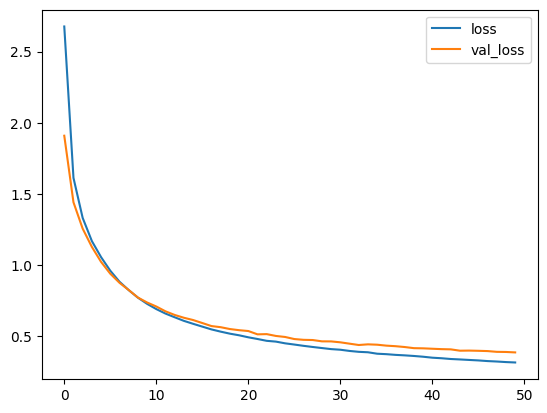

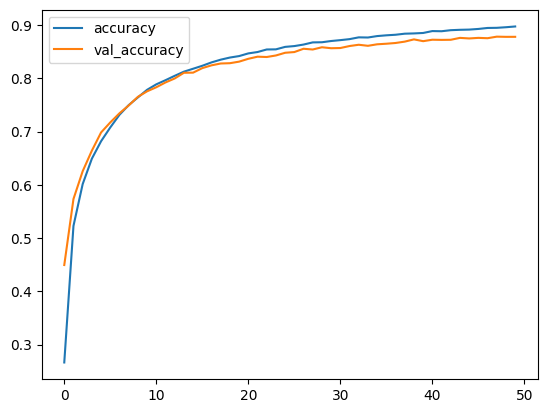

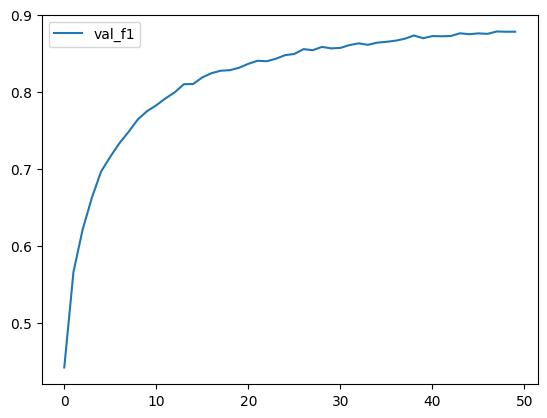

test loss: 0.39441091244072857, test accuracy: 0.8775, f1: 0.8773420831043693
best test loss: 0.38948337996316845, test accuracy: 0.8771634615384616, test f1: 0.8769679654957349


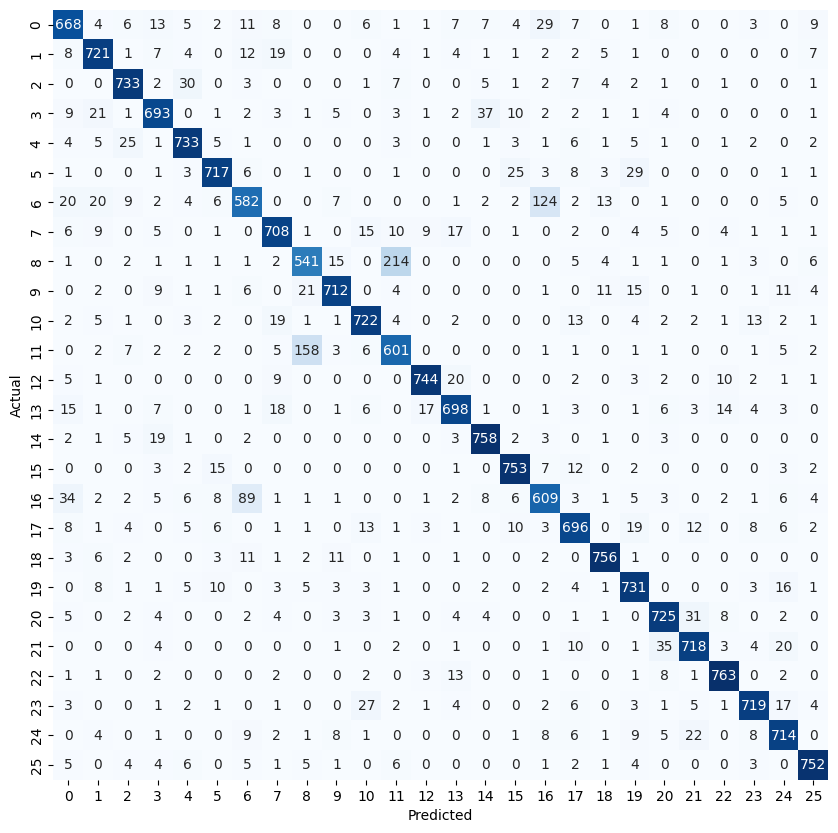

learning rate: 0.0025


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.0749, accuracy: 0.1445, val_loss: 2.7629, val_accuracy: 0.2743, val_f1: 0.2447


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 2.3167, accuracy: 0.3694, val_loss: 1.9620, val_accuracy: 0.4417, val_f1: 0.4274


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 1.7721, accuracy: 0.4823, val_loss: 1.6473, val_accuracy: 0.5178, val_f1: 0.5091


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 1.5385, accuracy: 0.5444, val_loss: 1.4692, val_accuracy: 0.5618, val_f1: 0.5560


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 1.3949, accuracy: 0.5852, val_loss: 1.3489, val_accuracy: 0.6008, val_f1: 0.5959


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 1.2927, accuracy: 0.6148, val_loss: 1.2680, val_accuracy: 0.6263, val_f1: 0.6231


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.2113, accuracy: 0.6396, val_loss: 1.1906, val_accuracy: 0.6479, val_f1: 0.6454


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.1444, accuracy: 0.6602, val_loss: 1.1321, val_accuracy: 0.6674, val_f1: 0.6650


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.0832, accuracy: 0.6764, val_loss: 1.0770, val_accuracy: 0.6780, val_f1: 0.6754


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.0335, accuracy: 0.6903, val_loss: 1.0323, val_accuracy: 0.6918, val_f1: 0.6906


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 0.9849, accuracy: 0.7043, val_loss: 0.9856, val_accuracy: 0.7066, val_f1: 0.7054


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 0.9444, accuracy: 0.7149, val_loss: 0.9453, val_accuracy: 0.7168, val_f1: 0.7154


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 0.9072, accuracy: 0.7264, val_loss: 0.9177, val_accuracy: 0.7243, val_f1: 0.7223


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 0.8718, accuracy: 0.7363, val_loss: 0.8823, val_accuracy: 0.7355, val_f1: 0.7338


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 0.8434, accuracy: 0.7440, val_loss: 0.8544, val_accuracy: 0.7423, val_f1: 0.7412


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 0.8145, accuracy: 0.7529, val_loss: 0.8220, val_accuracy: 0.7537, val_f1: 0.7523


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 0.7905, accuracy: 0.7608, val_loss: 0.8064, val_accuracy: 0.7536, val_f1: 0.7529


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 0.7685, accuracy: 0.7662, val_loss: 0.7808, val_accuracy: 0.7643, val_f1: 0.7631


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 0.7474, accuracy: 0.7734, val_loss: 0.7674, val_accuracy: 0.7669, val_f1: 0.7659


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 0.7274, accuracy: 0.7777, val_loss: 0.7411, val_accuracy: 0.7747, val_f1: 0.7739


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 0.7071, accuracy: 0.7839, val_loss: 0.7300, val_accuracy: 0.7771, val_f1: 0.7764


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 0.6909, accuracy: 0.7894, val_loss: 0.7195, val_accuracy: 0.7839, val_f1: 0.7835


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 0.6773, accuracy: 0.7922, val_loss: 0.6960, val_accuracy: 0.7893, val_f1: 0.7886


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 0.6590, accuracy: 0.7974, val_loss: 0.6844, val_accuracy: 0.7904, val_f1: 0.7899


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 0.6458, accuracy: 0.8023, val_loss: 0.6725, val_accuracy: 0.7957, val_f1: 0.7951


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 0.6323, accuracy: 0.8069, val_loss: 0.6615, val_accuracy: 0.7986, val_f1: 0.7982


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.6227, accuracy: 0.8086, val_loss: 0.6494, val_accuracy: 0.8011, val_f1: 0.8004


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.6115, accuracy: 0.8105, val_loss: 0.6414, val_accuracy: 0.8043, val_f1: 0.8036


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.5996, accuracy: 0.8149, val_loss: 0.6269, val_accuracy: 0.8104, val_f1: 0.8101


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.5887, accuracy: 0.8189, val_loss: 0.6178, val_accuracy: 0.8122, val_f1: 0.8115


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.5788, accuracy: 0.8226, val_loss: 0.6128, val_accuracy: 0.8110, val_f1: 0.8106


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.5702, accuracy: 0.8247, val_loss: 0.5953, val_accuracy: 0.8176, val_f1: 0.8172


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.5591, accuracy: 0.8277, val_loss: 0.5951, val_accuracy: 0.8185, val_f1: 0.8180


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.5507, accuracy: 0.8297, val_loss: 0.5812, val_accuracy: 0.8232, val_f1: 0.8228


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.5431, accuracy: 0.8336, val_loss: 0.5782, val_accuracy: 0.8220, val_f1: 0.8217


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.5328, accuracy: 0.8345, val_loss: 0.5702, val_accuracy: 0.8272, val_f1: 0.8271


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.5298, accuracy: 0.8368, val_loss: 0.5674, val_accuracy: 0.8249, val_f1: 0.8245


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.5195, accuracy: 0.8391, val_loss: 0.5548, val_accuracy: 0.8304, val_f1: 0.8298


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.5136, accuracy: 0.8414, val_loss: 0.5528, val_accuracy: 0.8334, val_f1: 0.8331


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.5089, accuracy: 0.8427, val_loss: 0.5435, val_accuracy: 0.8327, val_f1: 0.8325


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.5010, accuracy: 0.8434, val_loss: 0.5350, val_accuracy: 0.8331, val_f1: 0.8327


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.4960, accuracy: 0.8455, val_loss: 0.5387, val_accuracy: 0.8355, val_f1: 0.8350


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.4886, accuracy: 0.8475, val_loss: 0.5220, val_accuracy: 0.8388, val_f1: 0.8387


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.4832, accuracy: 0.8502, val_loss: 0.5274, val_accuracy: 0.8410, val_f1: 0.8408


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.4760, accuracy: 0.8517, val_loss: 0.5144, val_accuracy: 0.8391, val_f1: 0.8389


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.4730, accuracy: 0.8515, val_loss: 0.5077, val_accuracy: 0.8433, val_f1: 0.8431


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.4664, accuracy: 0.8550, val_loss: 0.5073, val_accuracy: 0.8437, val_f1: 0.8435


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.4600, accuracy: 0.8557, val_loss: 0.5089, val_accuracy: 0.8447, val_f1: 0.8446


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.4573, accuracy: 0.8574, val_loss: 0.4955, val_accuracy: 0.8471, val_f1: 0.8470


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.4508, accuracy: 0.8592, val_loss: 0.4938, val_accuracy: 0.8465, val_f1: 0.8461


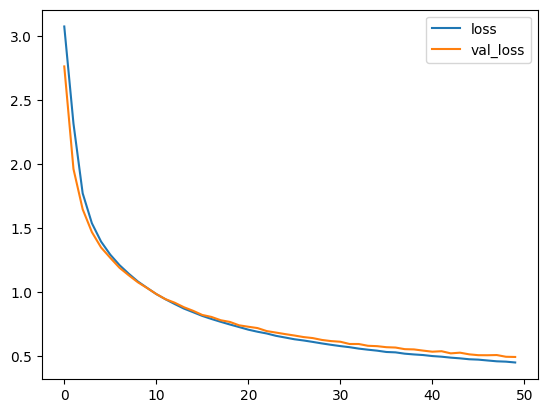

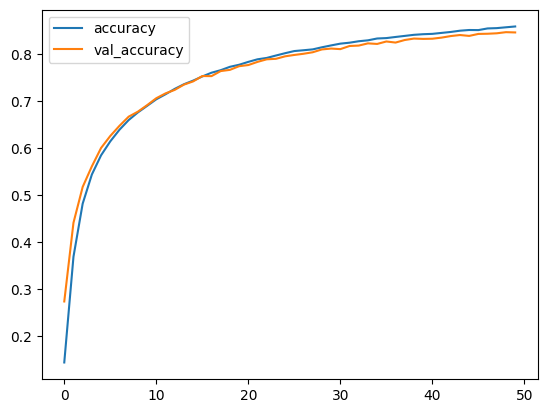

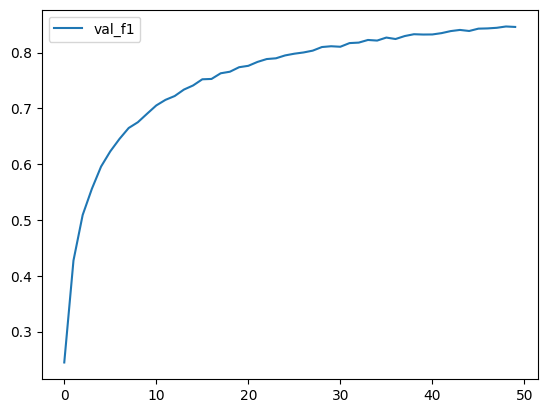

test loss: 0.49650281998404466, test accuracy: 0.846875, f1: 0.8466609989230149
best test loss: 0.49303265428495935, test accuracy: 0.8479326923076923, test f1: 0.8477188075617893


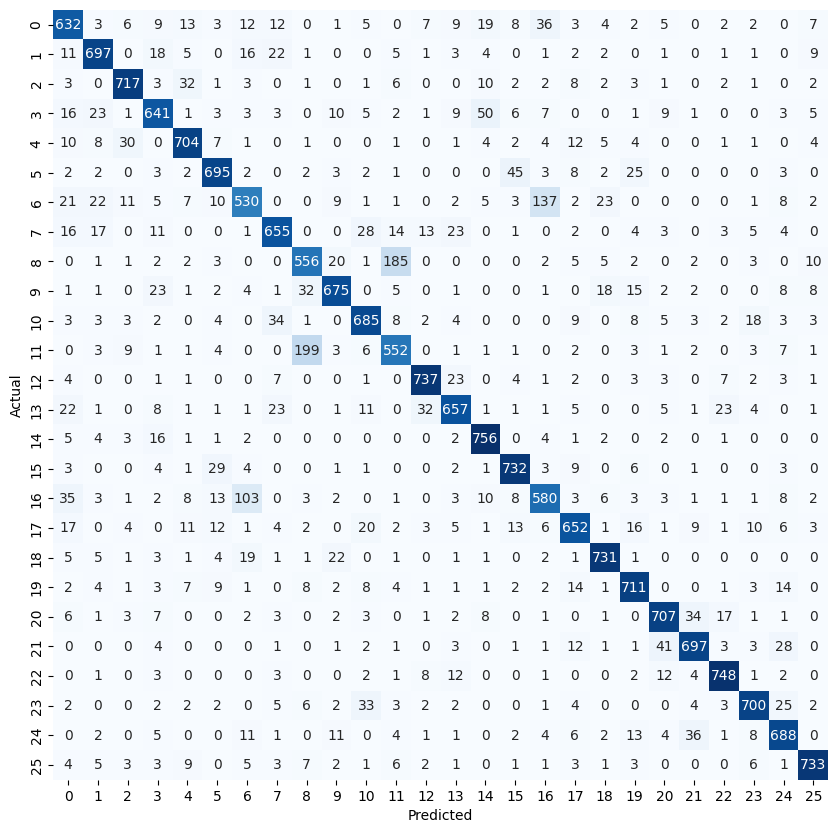

learning rate: 0.001


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.2191, accuracy: 0.0740, val_loss: 3.1672, val_accuracy: 0.1122, val_f1: 0.0875


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 3.0824, accuracy: 0.1595, val_loss: 2.9800, val_accuracy: 0.2029, val_f1: 0.1617


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 2.8271, accuracy: 0.2492, val_loss: 2.6573, val_accuracy: 0.2944, val_f1: 0.2619


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 2.4618, accuracy: 0.3360, val_loss: 2.2846, val_accuracy: 0.3762, val_f1: 0.3542


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 2.1365, accuracy: 0.4025, val_loss: 2.0210, val_accuracy: 0.4279, val_f1: 0.4135


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 1.9117, accuracy: 0.4483, val_loss: 1.8338, val_accuracy: 0.4693, val_f1: 0.4615


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.7541, accuracy: 0.4864, val_loss: 1.7075, val_accuracy: 0.5028, val_f1: 0.4957


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.6456, accuracy: 0.5137, val_loss: 1.6173, val_accuracy: 0.5233, val_f1: 0.5182


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.5643, accuracy: 0.5364, val_loss: 1.5363, val_accuracy: 0.5476, val_f1: 0.5419


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.4915, accuracy: 0.5575, val_loss: 1.4801, val_accuracy: 0.5596, val_f1: 0.5550


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 1.4382, accuracy: 0.5718, val_loss: 1.4257, val_accuracy: 0.5802, val_f1: 0.5769


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 1.3880, accuracy: 0.5874, val_loss: 1.3782, val_accuracy: 0.5951, val_f1: 0.5922


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 1.3471, accuracy: 0.6005, val_loss: 1.3404, val_accuracy: 0.6051, val_f1: 0.6025


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 1.3048, accuracy: 0.6101, val_loss: 1.3083, val_accuracy: 0.6098, val_f1: 0.6068


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 1.2724, accuracy: 0.6212, val_loss: 1.2709, val_accuracy: 0.6275, val_f1: 0.6256


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 1.2377, accuracy: 0.6299, val_loss: 1.2405, val_accuracy: 0.6304, val_f1: 0.6286


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 1.2094, accuracy: 0.6406, val_loss: 1.2098, val_accuracy: 0.6452, val_f1: 0.6423


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 1.1788, accuracy: 0.6464, val_loss: 1.1786, val_accuracy: 0.6535, val_f1: 0.6515


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 1.1495, accuracy: 0.6569, val_loss: 1.1556, val_accuracy: 0.6571, val_f1: 0.6545


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 1.1271, accuracy: 0.6625, val_loss: 1.1315, val_accuracy: 0.6670, val_f1: 0.6652


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 1.1019, accuracy: 0.6701, val_loss: 1.1020, val_accuracy: 0.6716, val_f1: 0.6700


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 1.0805, accuracy: 0.6757, val_loss: 1.0937, val_accuracy: 0.6767, val_f1: 0.6752


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 1.0604, accuracy: 0.6824, val_loss: 1.0709, val_accuracy: 0.6794, val_f1: 0.6779


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 1.0396, accuracy: 0.6878, val_loss: 1.0420, val_accuracy: 0.6871, val_f1: 0.6859


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 1.0211, accuracy: 0.6933, val_loss: 1.0282, val_accuracy: 0.6972, val_f1: 0.6959


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 1.0007, accuracy: 0.7003, val_loss: 1.0110, val_accuracy: 0.6952, val_f1: 0.6940


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.9798, accuracy: 0.7045, val_loss: 0.9965, val_accuracy: 0.7059, val_f1: 0.7043


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.9601, accuracy: 0.7105, val_loss: 0.9812, val_accuracy: 0.7065, val_f1: 0.7053


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.9475, accuracy: 0.7157, val_loss: 0.9632, val_accuracy: 0.7117, val_f1: 0.7104


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.9317, accuracy: 0.7189, val_loss: 0.9462, val_accuracy: 0.7162, val_f1: 0.7151


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.9213, accuracy: 0.7229, val_loss: 0.9444, val_accuracy: 0.7168, val_f1: 0.7159


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.9008, accuracy: 0.7285, val_loss: 0.9133, val_accuracy: 0.7238, val_f1: 0.7227


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.8914, accuracy: 0.7303, val_loss: 0.9068, val_accuracy: 0.7260, val_f1: 0.7251


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.8784, accuracy: 0.7356, val_loss: 0.8935, val_accuracy: 0.7319, val_f1: 0.7311


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.8648, accuracy: 0.7399, val_loss: 0.8860, val_accuracy: 0.7335, val_f1: 0.7329


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.8505, accuracy: 0.7431, val_loss: 0.8671, val_accuracy: 0.7385, val_f1: 0.7374


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.8414, accuracy: 0.7459, val_loss: 0.8545, val_accuracy: 0.7412, val_f1: 0.7401


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.8263, accuracy: 0.7505, val_loss: 0.8440, val_accuracy: 0.7441, val_f1: 0.7432


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.8160, accuracy: 0.7530, val_loss: 0.8338, val_accuracy: 0.7515, val_f1: 0.7506


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.8053, accuracy: 0.7572, val_loss: 0.8245, val_accuracy: 0.7525, val_f1: 0.7514


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.7958, accuracy: 0.7588, val_loss: 0.8178, val_accuracy: 0.7514, val_f1: 0.7506


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.7838, accuracy: 0.7626, val_loss: 0.8089, val_accuracy: 0.7556, val_f1: 0.7545


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.7715, accuracy: 0.7654, val_loss: 0.7959, val_accuracy: 0.7590, val_f1: 0.7582


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.7634, accuracy: 0.7686, val_loss: 0.7888, val_accuracy: 0.7621, val_f1: 0.7616


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.7557, accuracy: 0.7715, val_loss: 0.7803, val_accuracy: 0.7658, val_f1: 0.7651


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.7482, accuracy: 0.7735, val_loss: 0.7703, val_accuracy: 0.7659, val_f1: 0.7652


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.7366, accuracy: 0.7757, val_loss: 0.7647, val_accuracy: 0.7702, val_f1: 0.7693


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.7301, accuracy: 0.7778, val_loss: 0.7557, val_accuracy: 0.7694, val_f1: 0.7688


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.7222, accuracy: 0.7804, val_loss: 0.7535, val_accuracy: 0.7724, val_f1: 0.7718


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.7181, accuracy: 0.7829, val_loss: 0.7382, val_accuracy: 0.7779, val_f1: 0.7773


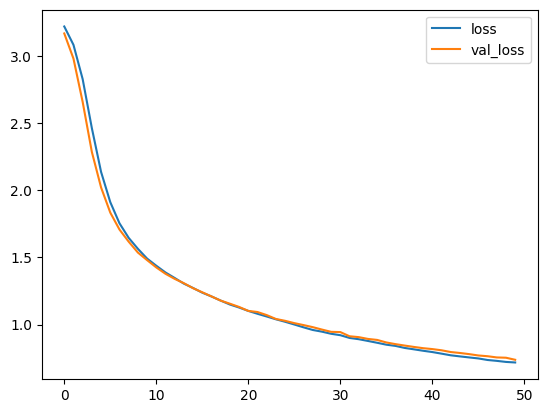

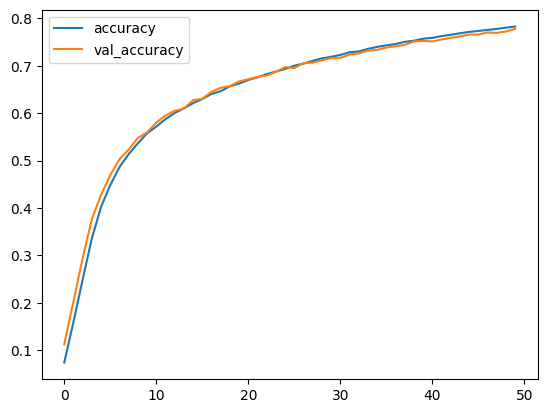

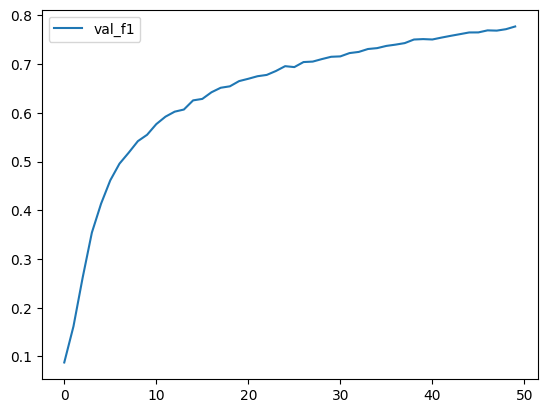

test loss: 0.7275209264479555, test accuracy: 0.7796634615384616, f1: 0.7788513769353371
best test loss: 0.7346842407856224, test accuracy: 0.7780769230769231, test f1: 0.7773129243972582


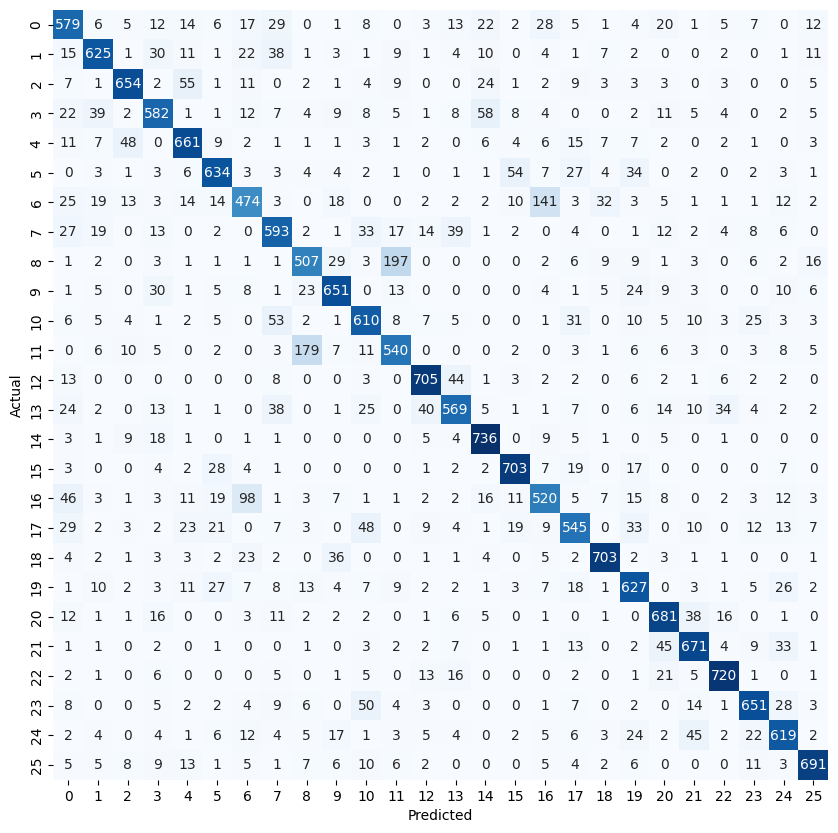

learning rate: 0.00075


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.2281, accuracy: 0.0659, val_loss: 3.1844, val_accuracy: 0.0928, val_f1: 0.0700


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 3.1234, accuracy: 0.1287, val_loss: 3.0511, val_accuracy: 0.1683, val_f1: 0.1394


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 2.9640, accuracy: 0.2104, val_loss: 2.8641, val_accuracy: 0.2518, val_f1: 0.2167


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 2.7368, accuracy: 0.2869, val_loss: 2.6039, val_accuracy: 0.3206, val_f1: 0.2855


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 2.4575, accuracy: 0.3467, val_loss: 2.3179, val_accuracy: 0.3701, val_f1: 0.3398


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 2.1903, accuracy: 0.3961, val_loss: 2.0880, val_accuracy: 0.4116, val_f1: 0.3936


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.9869, accuracy: 0.4371, val_loss: 1.9202, val_accuracy: 0.4527, val_f1: 0.4397


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.8443, accuracy: 0.4658, val_loss: 1.8010, val_accuracy: 0.4760, val_f1: 0.4656


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.7349, accuracy: 0.4927, val_loss: 1.7002, val_accuracy: 0.5017, val_f1: 0.4938


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.6564, accuracy: 0.5112, val_loss: 1.6314, val_accuracy: 0.5223, val_f1: 0.5149


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 1.5860, accuracy: 0.5320, val_loss: 1.5714, val_accuracy: 0.5341, val_f1: 0.5272


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 1.5355, accuracy: 0.5442, val_loss: 1.5305, val_accuracy: 0.5458, val_f1: 0.5406


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 1.4918, accuracy: 0.5571, val_loss: 1.4858, val_accuracy: 0.5543, val_f1: 0.5481


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 1.4496, accuracy: 0.5690, val_loss: 1.4492, val_accuracy: 0.5723, val_f1: 0.5671


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 1.4115, accuracy: 0.5793, val_loss: 1.4023, val_accuracy: 0.5844, val_f1: 0.5798


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 1.3752, accuracy: 0.5898, val_loss: 1.3780, val_accuracy: 0.5926, val_f1: 0.5886


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 1.3460, accuracy: 0.5975, val_loss: 1.3420, val_accuracy: 0.5994, val_f1: 0.5955


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 1.3182, accuracy: 0.6067, val_loss: 1.3217, val_accuracy: 0.6076, val_f1: 0.6043


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 1.2905, accuracy: 0.6147, val_loss: 1.2946, val_accuracy: 0.6156, val_f1: 0.6122


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 1.2619, accuracy: 0.6242, val_loss: 1.2697, val_accuracy: 0.6247, val_f1: 0.6210


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 1.2396, accuracy: 0.6307, val_loss: 1.2463, val_accuracy: 0.6327, val_f1: 0.6292


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 1.2161, accuracy: 0.6368, val_loss: 1.2239, val_accuracy: 0.6370, val_f1: 0.6343


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 1.1959, accuracy: 0.6413, val_loss: 1.2020, val_accuracy: 0.6442, val_f1: 0.6415


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 1.1749, accuracy: 0.6492, val_loss: 1.1862, val_accuracy: 0.6455, val_f1: 0.6424


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 1.1532, accuracy: 0.6554, val_loss: 1.1704, val_accuracy: 0.6507, val_f1: 0.6472


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 1.1345, accuracy: 0.6610, val_loss: 1.1492, val_accuracy: 0.6553, val_f1: 0.6523


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 1.1174, accuracy: 0.6650, val_loss: 1.1274, val_accuracy: 0.6628, val_f1: 0.6604


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 1.0978, accuracy: 0.6704, val_loss: 1.1099, val_accuracy: 0.6716, val_f1: 0.6692


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 1.0799, accuracy: 0.6767, val_loss: 1.0982, val_accuracy: 0.6712, val_f1: 0.6688


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 1.0643, accuracy: 0.6803, val_loss: 1.0756, val_accuracy: 0.6769, val_f1: 0.6748


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 1.0497, accuracy: 0.6851, val_loss: 1.0676, val_accuracy: 0.6832, val_f1: 0.6813


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 1.0348, accuracy: 0.6895, val_loss: 1.0527, val_accuracy: 0.6860, val_f1: 0.6838


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 1.0198, accuracy: 0.6941, val_loss: 1.0359, val_accuracy: 0.6906, val_f1: 0.6889


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 1.0032, accuracy: 0.6989, val_loss: 1.0226, val_accuracy: 0.6962, val_f1: 0.6946


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.9904, accuracy: 0.7032, val_loss: 1.0081, val_accuracy: 0.6957, val_f1: 0.6939


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.9746, accuracy: 0.7068, val_loss: 0.9969, val_accuracy: 0.6981, val_f1: 0.6964


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.9607, accuracy: 0.7098, val_loss: 0.9765, val_accuracy: 0.7100, val_f1: 0.7082


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.9480, accuracy: 0.7148, val_loss: 0.9682, val_accuracy: 0.7099, val_f1: 0.7085


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.9368, accuracy: 0.7185, val_loss: 0.9578, val_accuracy: 0.7167, val_f1: 0.7151


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.9265, accuracy: 0.7207, val_loss: 0.9461, val_accuracy: 0.7175, val_f1: 0.7161


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.9151, accuracy: 0.7235, val_loss: 0.9325, val_accuracy: 0.7199, val_f1: 0.7185


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.9007, accuracy: 0.7292, val_loss: 0.9230, val_accuracy: 0.7215, val_f1: 0.7203


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.8898, accuracy: 0.7338, val_loss: 0.9049, val_accuracy: 0.7303, val_f1: 0.7290


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.8792, accuracy: 0.7336, val_loss: 0.8996, val_accuracy: 0.7309, val_f1: 0.7292


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.8724, accuracy: 0.7358, val_loss: 0.8947, val_accuracy: 0.7322, val_f1: 0.7306


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.8609, accuracy: 0.7411, val_loss: 0.8839, val_accuracy: 0.7367, val_f1: 0.7356


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.8506, accuracy: 0.7425, val_loss: 0.8748, val_accuracy: 0.7388, val_f1: 0.7375


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.8416, accuracy: 0.7452, val_loss: 0.8647, val_accuracy: 0.7411, val_f1: 0.7401


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.8320, accuracy: 0.7490, val_loss: 0.8564, val_accuracy: 0.7433, val_f1: 0.7425


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.8229, accuracy: 0.7500, val_loss: 0.8462, val_accuracy: 0.7453, val_f1: 0.7440


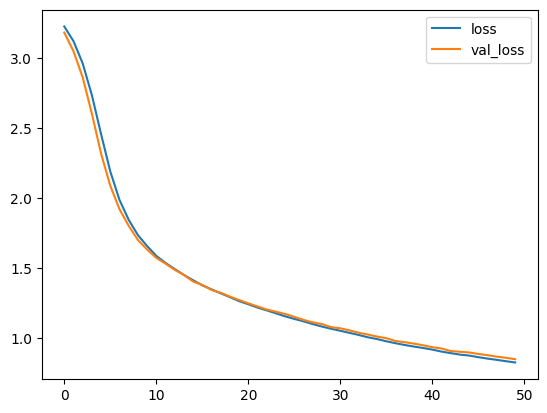

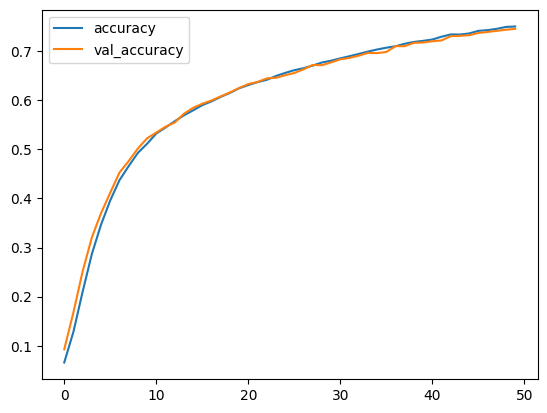

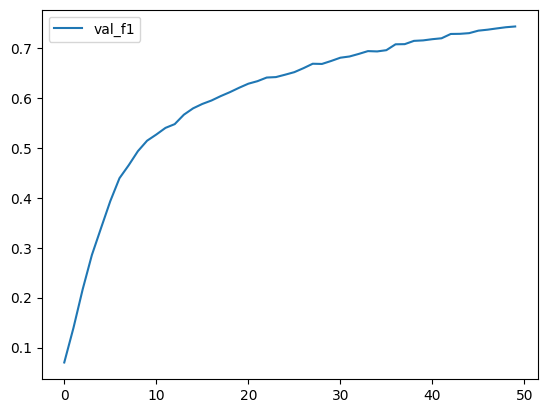

test loss: 0.8408099176840313, test accuracy: 0.7461538461538462, f1: 0.7452898011809452
best test loss: 0.8425269373203864, test accuracy: 0.743798076923077, test f1: 0.7425202341140064


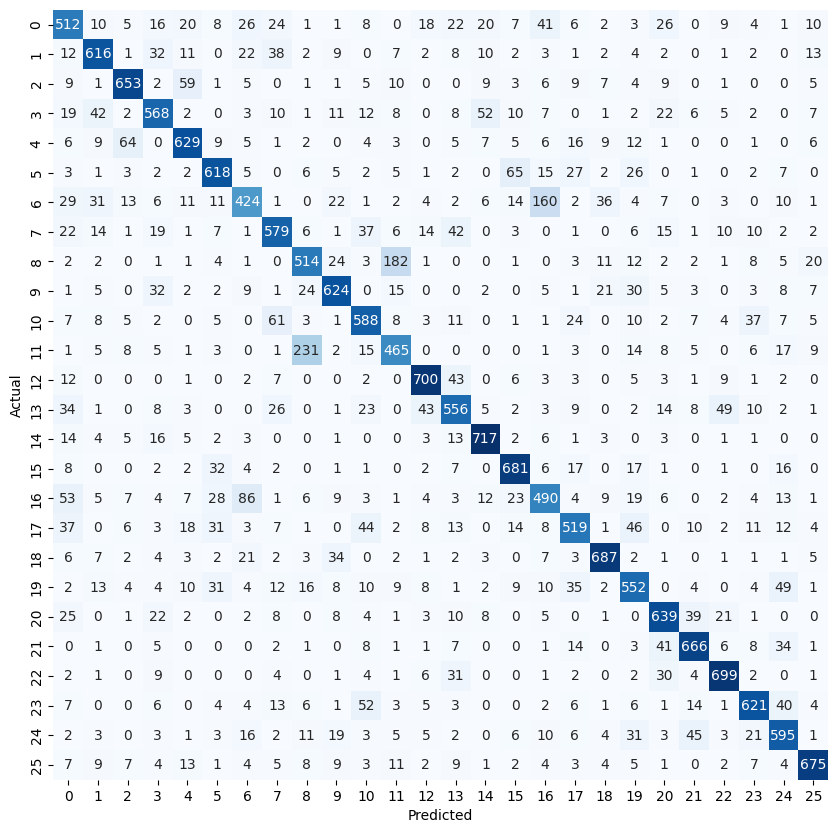

In [28]:
lr = [0.005, 0.0025, 0.001, 0.00075]
m = 5
for lrate in lr:
    print(f"learning rate: {lrate}")
    print("===============")
    model = FNN(
        loss=CategoricalCrossEntropyLoss(),
        optimizer=SGD(learning_rate=lrate),
        learning_rate=lrate,
        layers=[
            Flatten(),
            DenseLayer(input_size, 1024, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(1024, 512, ReLU()),
            DropoutLayer(dropout_rate=0.2),
            DenseLayer(512, 64, ReLU()),
            DropoutLayer(dropout_rate=0.1),
            DenseLayer(64, output_size, Softmax()),
        ]
    )


    # take only part after decimal point
    lrate_str = str(lrate).split(".")[1]

    # train
    model.fit(
        X=train_ds,
        y=train_labels,
        X_val=val_ds,
        y_val=val_labels,
        epochs=50,
        batch_size=64,
        best_name=f"best{m}_{lrate_str}.pkl"
    )

    # plot
    model.plot()

    # test model
    X_test = test_ds.data
    y_test = test_ds.targets
    test_loss, test_accuracy, f1 = model.evaluate(X_test, y_test)

    print(f"test loss: {test_loss}, test accuracy: {test_accuracy}, f1: {f1}")


    # test of best model
    test_loss, test_accuracy, f1 = model.best_model_evaluate(X_test, y_test)

    print(f"best test loss: {test_loss}, test accuracy: {test_accuracy}, test f1: {f1}")

    # plot confusion matrix
    model.plot_confusion_matrix(X_test, y_test)

    # save model
    model.save(f"last{m}_{lrate_str}.pkl")